In [3]:
# !pip install torch
# !pip install torchvision

In [4]:
import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Data Loading

[data] MNIST

https://en.wikipedia.org/wiki/MNIST_database

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5,),  # 평균 0.5
            (0.5,),  # 표준편차 0.5
        ),
    ]
)

In [6]:
train_set = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

test_set = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

100%|██████████| 9.91M/9.91M [00:09<00:00, 1.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.70MB/s]


In [26]:
print(f"train_set size: {len(train_set)}")
print(f"test_set size: {len(test_set)}")

train_set size: 60000
test_set size: 10000


In [28]:
for i in range(5):
    _, label = train_set[i]
    print(f"{i}번째 데이터 라벨: {label}")

0번째 데이터 라벨: 5
1번째 데이터 라벨: 0
2번째 데이터 라벨: 4
3번째 데이터 라벨: 1
4번째 데이터 라벨: 9


In [33]:
unique_labels_train = set([train_set[i][1] for i in range(len(train_set))])
unique_labels_test = set([test_set[i][1] for i in range(len(test_set))])

print(f"Unique labels in train_set: {unique_labels_train}")
print(f"Unique labels in test_set: {unique_labels_test}")

Unique labels in train_set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Unique labels in test_set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
labels = [train_set[i][1] for i in range(len(train_set))]
print(f"라벨 분포: {torch.bincount(torch.tensor(labels))}")

라벨 분포: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


In [7]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32,
    shuffle=False,
)

- batch_size 
    - 한 번에 모델 업데이트에 사용되는 데이터 개수 
    - 보통 32, 64, 128 같은 2의 배수를 많이 사용함 -> 32가 비교적 안정적인 기본값으로 활용 
    - GPU 연산 구조 상 2의 배수일 때 속도가 효율적인 경우가 많음 
    - (참고) DataLoader, `drop_last`
        - `False` : 마지막에 남는 데이터까지 작은 배치로 묶어서 반환 (default)
        - `True` : 마지막에 32개가 다 채워지지 않으면, 해당 배치는 버려짐 

- shuffle
    - train 
        - 데이터가 항상 같은 순서로 들어가면 특정 패턴에 치우칠 수 있음 (과적합 위험 있음) 
        - epoch 마다 데이터 순서를 섞어줘서 학습이 다양하게 되도록 함 
    - test
        - 평가 목적이므로 굳이 섞을 필요 없음 
        - 모든 데이터를 그대로 순서대로 넣어 정확도만 확인하면 됨 

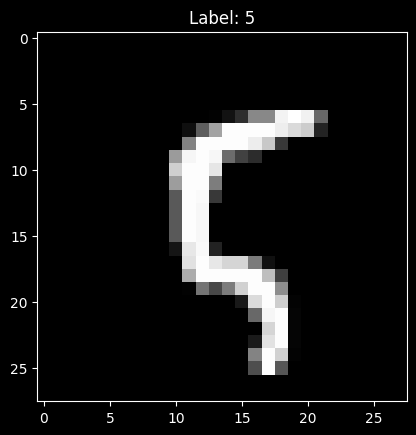

In [9]:
a_data, a_label = train_set[100]

plt.imshow(a_data.squeeze(), cmap="gray")
plt.title(f"Label: {a_label}")
plt.show()

In [10]:
a_data.shape

torch.Size([1, 28, 28])

# Architecture

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

- __init__ : 모델의 뼈대 만들기 
    - conv1 : 입력 채널수 1, 출력 채널수 32 => 입력(28 * 28) -> 출력(28 * 28, 채널 32개)
    - pool : 2 * 2 크기로 가장 큰 값만 남김 => 입력(28 * 28) -> 출력(14 * 14)
    - conv2 : 입력 채널 32, 출력 채널수 64 ==> 입력(14 * 14, 채널 32개) -> 출력(14 * 14, 채널 64개)
    - fc1 : 7 * 7 사이즈로 줄어든 특징맵 64개를 1차원으로 펼침 ==> 64 * 7 * 7=3136개를 128개 뉴런으로 변환 
    - fc2 : 128개 뉴런을 10개로 줄임 (10개 = 최종 라벨 개수)

- forward : 실제 데이터가 지나가는 길 
    - 입력 이미지 x (28 * 28) 들어오면...
    - conv1(x) : 32채널 28 * 28 출력 
    - pool : 32채널 14 * 14 출력 
    - conv2(x) : 64채널 14 * 14 출력 
    - pool : 64채널 7 * 7 출력 
    - x.view() : Flatten 처리 -> (batch_size, 64 * 7 * 7)
    - fc1(x) : 128개 뉴런 출력 
    - fc2(x) : 10개 뉴런 출력 

- 모델 흐름 

| Layer | Input size | Output size | Desc | 
|-------|------------|-------------|------|
| Conv1 + ReLU | (28, 28, 1) | (28, 28, 32) | 특징 추출 |
| MaxPool | (28, 28, 32) | (14, 14, 32) | 차원 축소 |
| Conv2 + ReLU | (14, 14, 32) | (14, 14, 64) | 더 깊은 특징 추출 |
| Maxpool | (14, 14, 64) | (7, 7, 64) | 차원 축소 |
| Flatten | (7, 7, 64) | (3136, ) | 펼치기 (2D->1D 변환) |
| fc1 + ReLU | (3136, ) | (128,) | 특징 결합 |
| fc2  | (128, ) | (10,) | 라벨 분류 (0~9 라벨) |

# Training

#### Setting

In [13]:
lr = 0.001

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### Training

In [20]:
num_epochs = 10
train_losses = []

**Training 단계**

- `optimizer.zero_grad()` : 기울기 초기화 (이전 스텝 영향 제거) 
- `loss.backward()` : 오차(손실)에 대한 기울기 계산 
- `optimizer.step()` : 계산 기울기 기반으로 가중치 업데이트 
- loss 처리 
    - running_loss : 단계별 loss 누적 합 
    - len(train_loader) = batch 개수 
    - 나눠서 얻는 값 : epoch loss average 

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_losses.append(running_loss / len(train_loader))

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.1297
Epoch 2, Loss: 0.0431
Epoch 3, Loss: 0.0290
Epoch 4, Loss: 0.0223
Epoch 5, Loss: 0.0164
Epoch 6, Loss: 0.0118
Epoch 7, Loss: 0.0100
Epoch 8, Loss: 0.0093
Epoch 9, Loss: 0.0069
Epoch 10, Loss: 0.0076


# Evaluation

In [30]:
correct = 0
total = 0
misclassified_samples = []

In [ ]:
# eval 단계에서는 gradient 계산 불필요
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # 가장 높은 확률을 가진 클래스 선택 
        _, predicted = torch.max(outputs, 1)

        # 전체 샘플수 누적 
        total += labels.size(0)

        # 정답과 예측이 일치하는 샘플수 누적 
        correct += (predicted == labels).sum().item()

        # 오분류 샘플의 인덱스 추출 
        misclassified = (predicted != labels).nonzero(as_tuple=True)[0]

        # 오분류 샘플 취합 (입력데이터, 예측값, 실제값) 
        for idx in misclassified:
            misclassified_samples.append(
                (inputs[idx].cpu(), predicted[idx].cpu(), labels[idx].cpu())
            )

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9885


## Training Loss

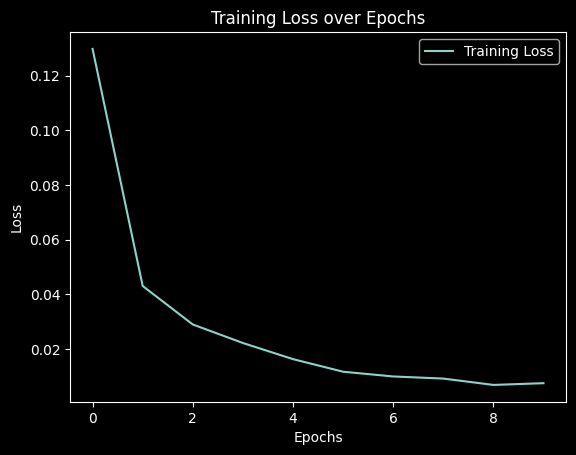

In [24]:
plt.plot(train_losses, label="Training Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Results

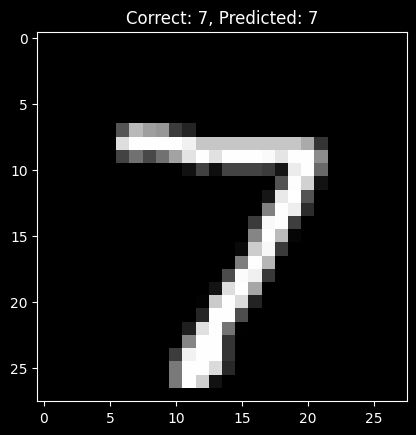

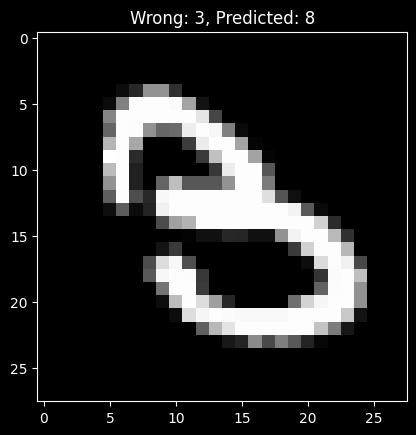

In [32]:
correct_sample = None
for i in range(len(test_set)):
    img, label = test_set[i]
    img_tensor = img.unsqueeze(0).to(device)
    output = model(img_tensor)
    _, pred = torch.max(output, 1)
    if pred.item() == label:
        correct_sample = (img, label, pred.item())
        break

if correct_sample:
    plt.imshow(correct_sample[0].squeeze(), cmap="gray")
    plt.title(f"Correct: {correct_sample[1]}, Predicted: {correct_sample[2]}")
    plt.show()

# 틀린 것
if misclassified_samples:
    img, pred, label = misclassified_samples[0]
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Wrong: {label}, Predicted: {pred}")
    plt.show()

# End of Documents